In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import spacy
nlp = spacy.load('en_core_web_sm')

stopwords = stopwords.words('english')
sns.set_context('notebook')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# References:
1. https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras

2. https://spacy.io/usage/processing-pipelines

In [4]:
df = pd.read_csv('samples_no_title.csv',
                usecols=['Grade','Text']).dropna()
df

Grade                                               Text
0      1.0  I had just gone to Chobot Space and Science Ce...
1      1.0  My cat is fluffy. His name is Buzz. He is my f...
2      1.0   Spring is sweet because we can go boat riding...
3      1.0  One day baby Josh came home. He was in a yello...
4      1.0  One time I went to Mexico. It was a blast! I m...
..     ...                                                ...
318   12.0  The modern world is full of problems and issue...
319   12.0  The violin is arguably the most cherished and ...
320   12.0  Have you ever wondered how to design complex w...
321   12.0  Welding is a highly demanded trade across the ...
322    2.0  Lex go to step 1: Get all the dings you need. ...

[322 rows x 2 columns]

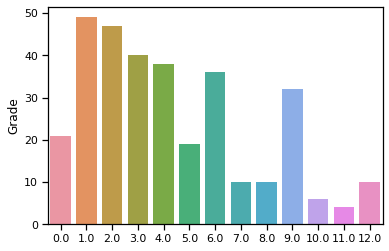

In [5]:
sns.barplot(x=df.Grade.unique(),y=df.Grade.value_counts())

In [6]:
all_text = ' '.join([story for story in df.Text])

In [7]:
wordcloud = WordCloud().generate(all_text)

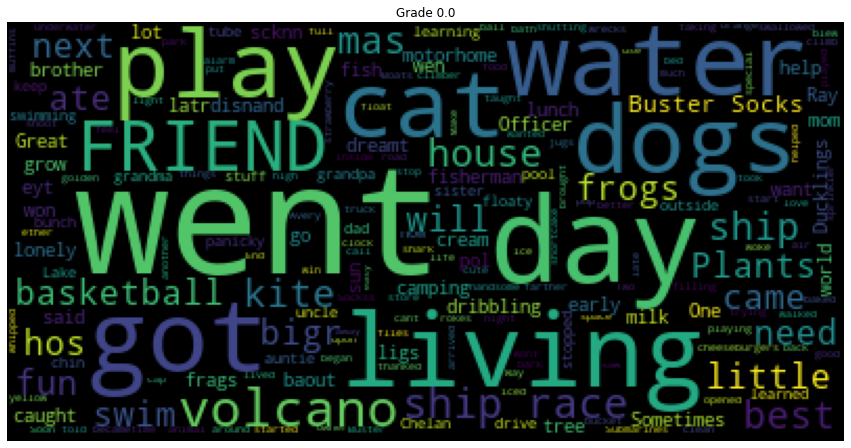

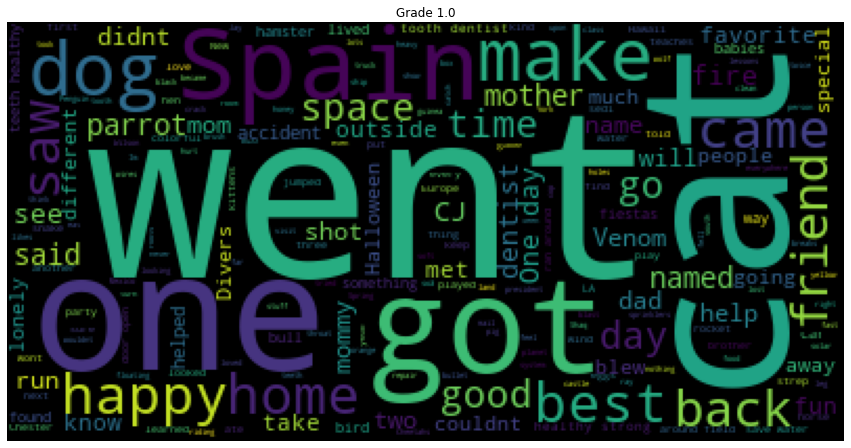

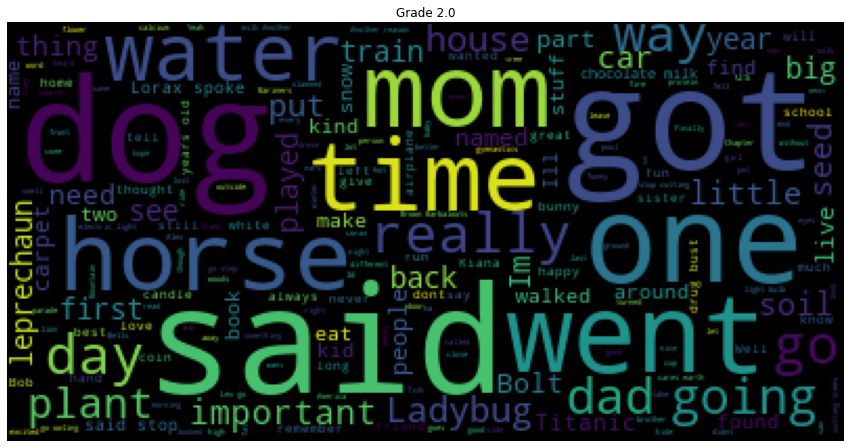

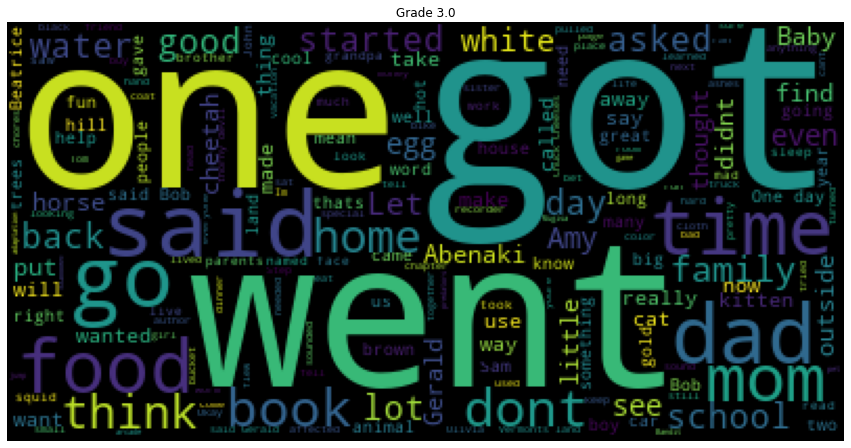

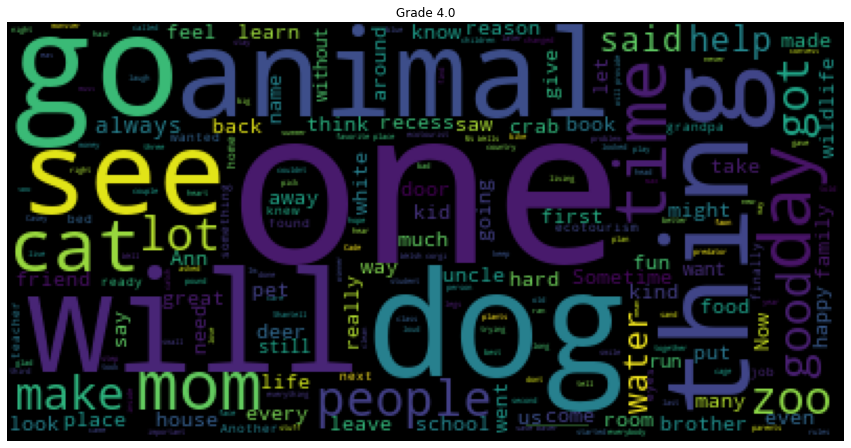

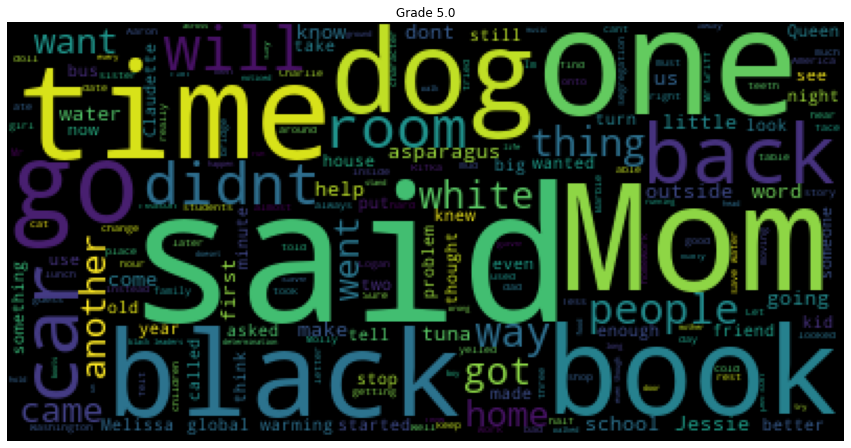

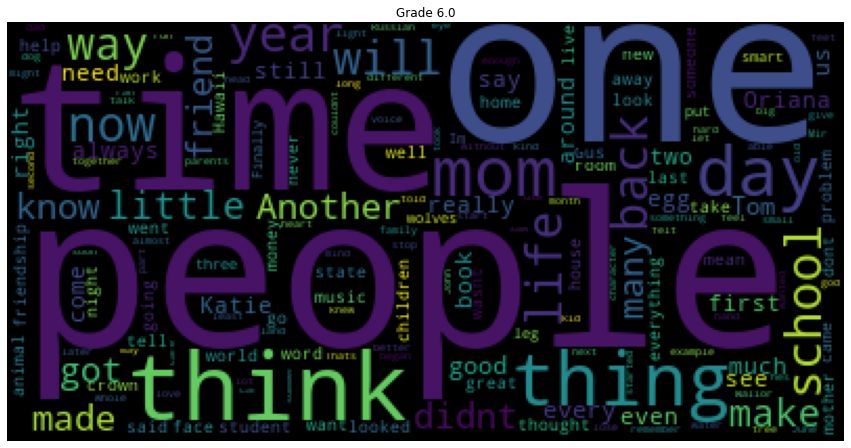

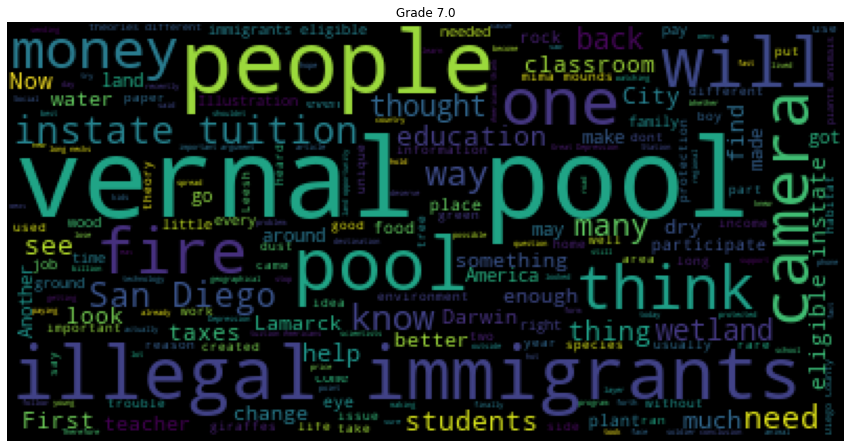

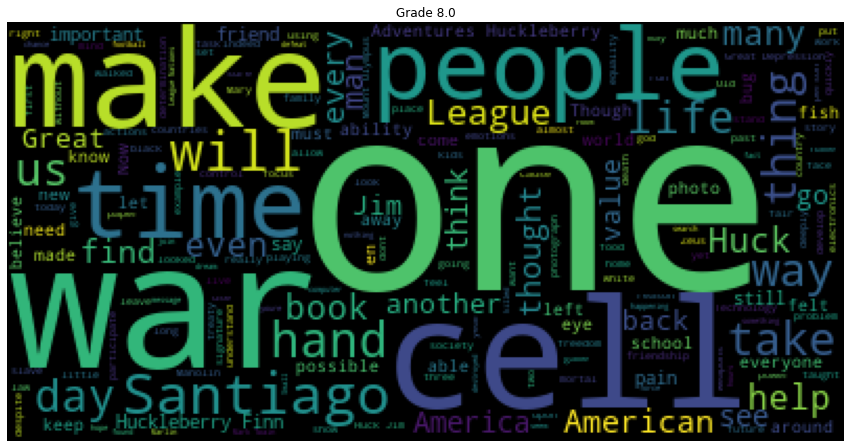

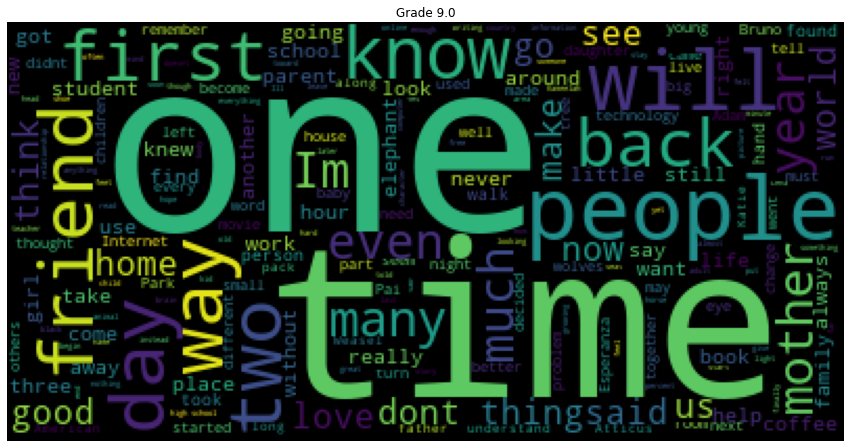

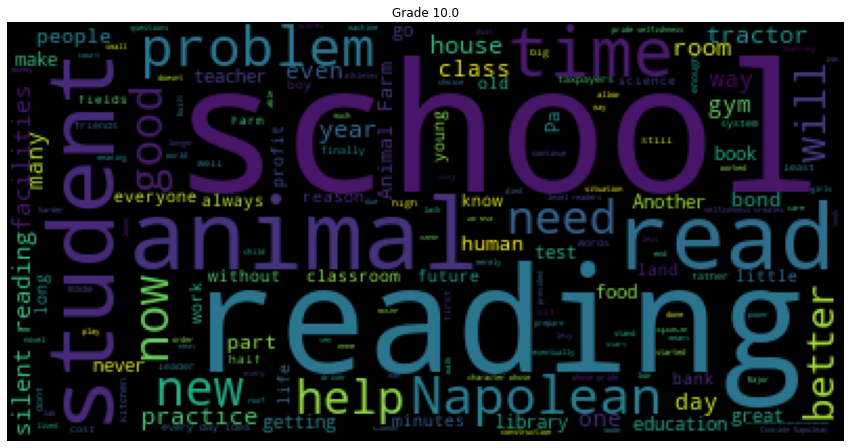

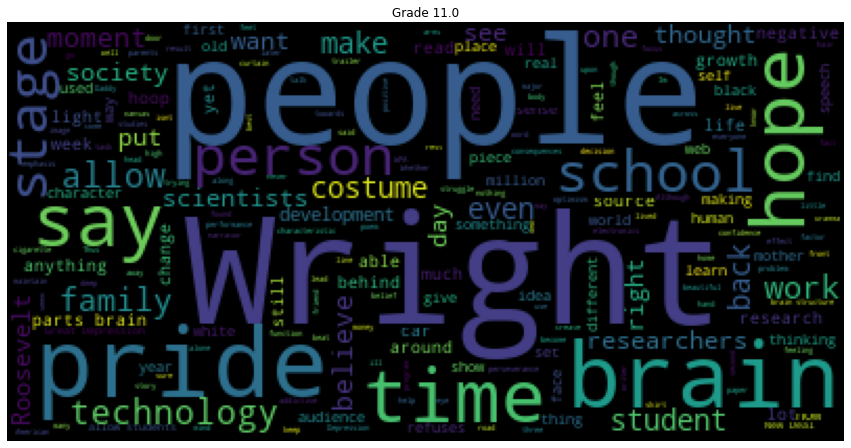

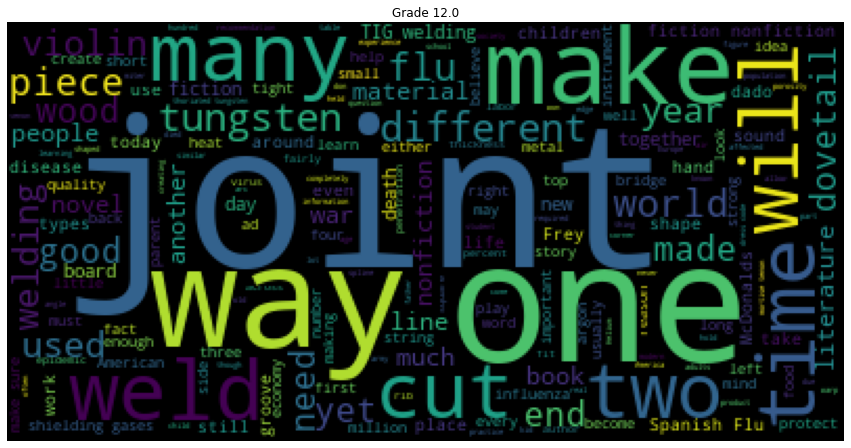

In [8]:
for grade in sorted(df.Grade.unique()):
    text = ' '.join([story for story in df.loc[df.Grade == grade, 'Text']])
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(15,12))
    plt.imshow(wordcloud)
    plt.title('Grade {}'.format(grade))
    plt.axis('off')
    plt.show()

In [9]:
def vectorize_text(series, lemmatize=False):
    vectors = []
    if lemmatize:
        lemmafied = []

        for doc in nlp.pipe(series):
            lemmas = [tok.lemma_ for tok in doc]
            lemmas = [lemma for lemma in lemmas if lemma not in stopwords and lemma not in punctuation]
            lemmas = ' '.join(lemmas)
            lemmafied.append(lemmas)
        series = lemmafied
    for doc in nlp.pipe(series):
        vectors.append(doc.vector)
    return np.asarray(vectors).astype('float32')

In [10]:

X=df.Text
y=df.Grade
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

In [11]:
train_sents = pd.DataFrame(columns=['Text','Grade'])
for text, grade in zip(X_train, y_train):
    sents = text.split('.')
    for sent in sents:
        train_sents = train_sents.append({'Text':sent,'Grade':grade}, ignore_index=True)
train_sents = train_sents.loc[train_sents['Text'] != '']
X_train_sents = vectorize_text(train_sents.Sentence)
y_train_sents = train_sents.Grade

In [12]:
X_train_sents.shape

(7041, 96)

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

In [16]:
def build_MLP():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=96))
#     model.add(Dropout(rate=.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))

    model.add(Dense(512, activation='relu'))
#     model.add(Dropout(rate=.2))
    model.add(Dense(512, activation='relu'))
#     model.add(Dropout(rate=.2))
    model.add(Dense(512, activation='relu'))
#     model.add(Dropout(rate=.2))
    model.add(Dense(512, activation='relu'))
#     model.add(Dropout(rate=.2))
    model.add(Dense(1, activation='relu'))
    sgd = SGD(lr=.01, 
              decay=1e-3,
             )
    model.compile(optimizer=sgd, loss='mean_absolute_error')
    return model
model = build_MLP()
model.fit(X_train_sents,
         y_train_sents,
         epochs=1000,
        batch_size=1000,
         validation_split = .2,
         verbose=1)

Epoch 1/1000
6/6 [==============================] - 2s 210ms/step - loss: 6.6902 - val_loss: 6.6132
Epoch 2/1000
6/6 [==============================] - 1s 170ms/step - loss: 6.0601 - val_loss: 5.3974
Epoch 3/1000
6/6 [==============================] - 1s 170ms/step - loss: 4.3997 - val_loss: 3.1916
Epoch 4/1000
6/6 [==============================] - 1s 172ms/step - loss: 2.7250 - val_loss: 3.0641
Epoch 5/1000
6/6 [==============================] - 1s 172ms/step - loss: 2.6421 - val_loss: 2.9676
Epoch 6/1000
6/6 [==============================] - 1s 171ms/step - loss: 2.5949 - val_loss: 2.9019
Epoch 7/1000
6/6 [==============================] - 1s 172ms/step - loss: 2.5282 - val_loss: 2.8591
Epoch 8/1000
6/6 [==============================] - 1s 174ms/step - loss: 2.4965 - val_loss: 2.8226
Epoch 9/1000
6/6 [==============================] - 1s 171ms/step - loss: 2.4635 - val_loss: 2.7954
Epoch 10/1000
6/6 [==============================] - 1s 170ms/step - loss: 2.4439 - val_loss: 2.7736

In [20]:
def evaluate_model(model, X_text, y_test):
    errors = pd.DataFrame(X_test).reset_index()
    errors['True'] = y_test.reset_index(drop=True)
    for i, text in enumerate(X_test):
        preds = 0
        sent_count = 0
        for sent in text.split('.'):
            vec = nlp(sent).vector.reshape(1,-1)
            if vec != []:
                sent_count += 1
                preds += model.predict(vec)[0]
        if sent_count > 0:
            avg_pred = preds/sent_count
        else: avg_pred = np.nan
        errors.loc[i,'Prediction'] = avg_pred
    errors['error'] = errors['True'] - errors['Prediction']
    print('MAE = ', np.abs(errors['error']).mean())
    return errors

In [21]:
evaluate_model(model, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


MAE =  2.177728232042289


index  ...     error
0       0  ... -3.973805
1     232  ...  4.917036
2      52  ... -0.939947
3      15  ... -3.184471
4     257  ...  0.839778
..    ...  ...       ...
76    158  ...  3.158400
77    256  ...  0.629369
78    224  ...  1.437825
79    300  ... -1.617677
80    194  ... -5.943356

[81 rows x 5 columns]

In [ ]:
errors.describe()

In [ ]:
def build_LSTM():
    model = Sequential()
    model.add_layer(Input())